In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn 
import torch.optim as optim

import copy
import tqdm

import util
import os 

In [2]:
cwd = os.getcwd()
print(cwd)

/home/linhnm/msc_code/big_data_mining/eabdt/python


In [3]:
dataset = 'mix'

training_batch_from = 0
training_batch_to = 3000
val_batch_from = 3000
val_batch_to = 3600

testing_batch_from = 0
testing_batch_to = 400

# training_batch_from = 0
# training_batch_to = 40
# val_batch_from = 40
# val_batch_to = 50

# testing_batch_from = 0
# testing_batch_to = 8

In [4]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda:0'
  print('ok')

ok


In [5]:
X_train = util.load_vector(os.path.join(cwd, '../data/vectorize/384/mix/training_set'), training_batch_from, training_batch_to)
y_train = util.load_label(os.path.join(cwd, '../data/raw/mix/training_set'), training_batch_from, training_batch_to)

X_val = util.load_vector(os.path.join(cwd, '../data/vectorize/384/mix/training_set'), val_batch_from, val_batch_to)
y_val = util.load_label(os.path.join(cwd, '../data/raw/mix/training_set'), val_batch_from, val_batch_to)

X_test = util.load_vector(os.path.join(cwd, '../data/vectorize/384/mix/testing_set'), testing_batch_from, testing_batch_to)
y_test = util.load_label(os.path.join(cwd, '../data/raw/mix/testing_set'), testing_batch_from, testing_batch_to)

In [6]:
X_train.shape

(3000000, 384)

In [7]:
epochs = 200
trigger = 1
early_stopping_round = 20

input_dim = 384
# input_dim = 768
output_dim = 1
learning_rate = 0.1

In [8]:
class SimpleSoftmax(nn.Module):
  # Constructor
  def __init__(self, input_size, hidden_neurons, output_size):
    super(SimpleSoftmax, self).__init__()
    # hidden layer 
    self.linear_one = torch.nn.Linear(input_size, hidden_neurons, bias=True)
    self.linear_two = torch.nn.Linear(hidden_neurons, output_size, bias=True) 
    # defining layers as attributes
    self.layer_in = None
    self.act = None
    self.layer_out = None
  # prediction function
  def forward(self, x):
    self.layer_in = self.linear_one(x)
    self.act = torch.sigmoid(self.layer_in)
    self.layer_out = self.linear_two(self.act)
    y_pred = torch.sigmoid(self.linear_two(self.act))
    return y_pred

In [9]:
model = SimpleSoftmax(input_dim, 64, output_dim)
model.to(device)

SimpleSoftmax(
  (linear_one): Linear(in_features=384, out_features=64, bias=True)
  (linear_two): Linear(in_features=64, out_features=1, bias=True)
)

In [10]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
# X_gpu_train = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_gpu_train = torch.flatten(torch.tensor(y_train).type(torch.float32)).to(device)
X_gpu_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_gpu_val = torch.flatten(torch.tensor(y_val).type(torch.float32)).to(device)
X_gpu_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_gpu_test = torch.flatten(torch.tensor(y_test).type(torch.float32)).to(device)

In [12]:
import time
tol_acc = 2
warming = 20
losses = []
losses_val = []
acc_train = []
acc_val = []
Iterations = []
best_loss = torch.tensor(np.inf).to(device)
best_acc = 0
best_weights = None
iter = 0
early = 0
start = time.time()
mini_batch_size = 1024
num_mini_batch = int(X_train.shape[0] / mini_batch_size)
# X_gpu_train_shuffle = X_gpu_train
for epoch in tqdm.tqdm(range(int(epochs)),desc='Training Epochs'):
    
    for bid in range(num_mini_batch):
        idx = np.random.randint(X_train.shape[0], size=mini_batch_size)
        X_train_batch = X_train[idx, :]
        x = torch.tensor(X_train_batch, dtype=torch.float32).to(device)
        # indices = torch.randperm(X_gpu_train.shape[0])[:mini_batch_size]
        # x = X_gpu_train[indices]
    
        # start = time.time()
        # x = X_gpu_train
        # labels = y_gpu_train[indices]
        y_train_batch = y_train[idx]
        labels = torch.flatten(torch.tensor(y_train_batch).type(torch.float32)).to(device)
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(x)
        loss = criterion(torch.squeeze(outputs), labels) 

        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

        optimizer.step() # Updates weights and biases with the optimizer (SGD)
        
        # print(f"Train -  Loss: {loss.item()}, batch: {bid}")
    
    iter+=1
    early+=1
    if iter%trigger==0:
        early+=1
        with torch.no_grad():
            # Calculating the loss and accuracy for the val dataset
            correct_val = 0
            total_val = 0
            outputs_val = torch.squeeze(model(X_gpu_val))
            loss_val = criterion(outputs_val, y_gpu_val)
            
            # predicted_val = outputs_val.round()
            total_val += y_gpu_val.size(0)
            correct_val += torch.eq(outputs_val.round(), y_gpu_val).sum()
            accuracy_val = 100 * correct_val/total_val
            losses_val.append(loss_val.item())
            acc_val.append(accuracy_val.item())
            
            # Calculating the loss and accuracy for the train dataset
            # total = 0
            # correct = 0
            # total += y_gpu_train.size(0)
            # # correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_gpu_train.detach().numpy())
            # correct += torch.eq(torch.squeeze(outputs).round(), y_gpu_train).sum()
            # accuracy = 100 * correct/total
            # losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nVal - Loss: {loss_val.item()}. Accuracy: {accuracy_val}")
            # print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
            
            if accuracy_val > best_acc:
                print(f'\tBetter accuracy: {accuracy_val}')
                best_acc = accuracy_val
                best_weights = copy.deepcopy(model.state_dict())
            elif epoch > warming and (best_acc - accuracy_val) > tol_acc:
                print(f'early stopping, current accuracy: {accuracy_val}')
                break    

end = time.time()
total_time = round(end - start, 3)


Training Epochs:   0%|          | 1/200 [00:04<13:43,  4.14s/it]

Iteration: 1. 
Val - Loss: 0.5170267820358276. Accuracy: 80.74516296386719
	Better accuracy: 80.74516296386719


Training Epochs:   1%|          | 2/200 [00:07<12:14,  3.71s/it]

Iteration: 2. 
Val - Loss: 0.37214356660842896. Accuracy: 84.12633514404297
	Better accuracy: 84.12633514404297


Training Epochs:   2%|▏         | 3/200 [00:11<11:51,  3.61s/it]

Iteration: 3. 
Val - Loss: 0.3486553728580475. Accuracy: 85.1181640625
	Better accuracy: 85.1181640625


Training Epochs:   2%|▏         | 4/200 [00:14<11:37,  3.56s/it]

Iteration: 4. 
Val - Loss: 0.33990368247032166. Accuracy: 85.50516510009766
	Better accuracy: 85.50516510009766


Training Epochs:   2%|▎         | 5/200 [00:18<11:37,  3.57s/it]

Iteration: 5. 
Val - Loss: 0.3355334401130676. Accuracy: 85.72283172607422
	Better accuracy: 85.72283172607422


Training Epochs:   3%|▎         | 6/200 [00:21<11:25,  3.54s/it]

Iteration: 6. 
Val - Loss: 0.3329738676548004. Accuracy: 85.82366943359375
	Better accuracy: 85.82366943359375


Training Epochs:   4%|▎         | 7/200 [00:24<11:13,  3.49s/it]

Iteration: 7. 
Val - Loss: 0.3310285806655884. Accuracy: 85.92683410644531
	Better accuracy: 85.92683410644531


Training Epochs:   4%|▍         | 8/200 [00:28<11:01,  3.44s/it]

Iteration: 8. 
Val - Loss: 0.3295973837375641. Accuracy: 85.99250030517578
	Better accuracy: 85.99250030517578


Training Epochs:   4%|▍         | 9/200 [00:31<10:54,  3.43s/it]

Iteration: 9. 
Val - Loss: 0.3284662067890167. Accuracy: 86.05116271972656
	Better accuracy: 86.05116271972656


Training Epochs:   5%|▌         | 10/200 [00:35<10:49,  3.42s/it]

Iteration: 10. 
Val - Loss: 0.3276553153991699. Accuracy: 86.08633422851562
	Better accuracy: 86.08633422851562


Training Epochs:   6%|▌         | 11/200 [00:38<10:40,  3.39s/it]

Iteration: 11. 
Val - Loss: 0.32688602805137634. Accuracy: 86.11883544921875
	Better accuracy: 86.11883544921875


Training Epochs:   6%|▌         | 12/200 [00:41<10:28,  3.34s/it]

Iteration: 12. 
Val - Loss: 0.32608500123023987. Accuracy: 86.17583465576172
	Better accuracy: 86.17583465576172


Training Epochs:   6%|▋         | 13/200 [00:45<10:30,  3.37s/it]

Iteration: 13. 
Val - Loss: 0.32595062255859375. Accuracy: 86.16500091552734


Training Epochs:   7%|▋         | 14/200 [00:48<10:28,  3.38s/it]

Iteration: 14. 
Val - Loss: 0.32533079385757446. Accuracy: 86.19416809082031
	Better accuracy: 86.19416809082031


Training Epochs:   8%|▊         | 15/200 [00:51<10:12,  3.31s/it]

Iteration: 15. 
Val - Loss: 0.3247804045677185. Accuracy: 86.22550201416016
	Better accuracy: 86.22550201416016


Training Epochs:   8%|▊         | 16/200 [00:55<10:19,  3.37s/it]

Iteration: 16. 
Val - Loss: 0.32441818714141846. Accuracy: 86.23866271972656
	Better accuracy: 86.23866271972656


Training Epochs:   8%|▊         | 17/200 [00:58<10:21,  3.39s/it]

Iteration: 17. 
Val - Loss: 0.3238334655761719. Accuracy: 86.2770004272461
	Better accuracy: 86.2770004272461


Training Epochs:   9%|▉         | 18/200 [01:02<10:20,  3.41s/it]

Iteration: 18. 
Val - Loss: 0.3234654664993286. Accuracy: 86.29366302490234
	Better accuracy: 86.29366302490234


Training Epochs:  10%|▉         | 19/200 [01:05<10:12,  3.39s/it]

Iteration: 19. 
Val - Loss: 0.32327812910079956. Accuracy: 86.29366302490234


Training Epochs:  10%|█         | 20/200 [01:08<10:06,  3.37s/it]

Iteration: 20. 
Val - Loss: 0.32295721769332886. Accuracy: 86.32050323486328
	Better accuracy: 86.32050323486328


Training Epochs:  10%|█         | 21/200 [01:12<10:01,  3.36s/it]

Iteration: 21. 
Val - Loss: 0.3229927718639374. Accuracy: 86.29983520507812


Training Epochs:  11%|█         | 22/200 [01:15<10:03,  3.39s/it]

Iteration: 22. 
Val - Loss: 0.3225105106830597. Accuracy: 86.33983612060547
	Better accuracy: 86.33983612060547


Training Epochs:  12%|█▏        | 23/200 [01:18<09:57,  3.38s/it]

Iteration: 23. 
Val - Loss: 0.3223254084587097. Accuracy: 86.3550033569336
	Better accuracy: 86.3550033569336


Training Epochs:  12%|█▏        | 24/200 [01:22<09:56,  3.39s/it]

Iteration: 24. 
Val - Loss: 0.3228435516357422. Accuracy: 86.3066635131836


Training Epochs:  12%|█▎        | 25/200 [01:25<09:52,  3.39s/it]

Iteration: 25. 
Val - Loss: 0.3219894468784332. Accuracy: 86.35350036621094


Training Epochs:  13%|█▎        | 26/200 [01:29<09:57,  3.43s/it]

Iteration: 26. 
Val - Loss: 0.3219051957130432. Accuracy: 86.36100006103516
	Better accuracy: 86.36100006103516


Training Epochs:  14%|█▎        | 27/200 [01:32<09:52,  3.42s/it]

Iteration: 27. 
Val - Loss: 0.321730375289917. Accuracy: 86.37616729736328
	Better accuracy: 86.37616729736328


Training Epochs:  14%|█▍        | 28/200 [01:36<09:55,  3.46s/it]

Iteration: 28. 
Val - Loss: 0.3216872811317444. Accuracy: 86.36799621582031


Training Epochs:  14%|█▍        | 29/200 [01:39<09:50,  3.45s/it]

Iteration: 29. 
Val - Loss: 0.3216463327407837. Accuracy: 86.3673324584961


Training Epochs:  15%|█▌        | 30/200 [01:43<09:48,  3.46s/it]

Iteration: 30. 
Val - Loss: 0.3215330243110657. Accuracy: 86.39700317382812
	Better accuracy: 86.39700317382812


Training Epochs:  16%|█▌        | 31/200 [01:46<09:43,  3.45s/it]

Iteration: 31. 
Val - Loss: 0.32133784890174866. Accuracy: 86.38800048828125


Training Epochs:  16%|█▌        | 32/200 [01:49<09:40,  3.46s/it]

Iteration: 32. 
Val - Loss: 0.3212474584579468. Accuracy: 86.39533233642578


Training Epochs:  16%|█▋        | 33/200 [01:53<09:33,  3.44s/it]

Iteration: 33. 
Val - Loss: 0.32121536135673523. Accuracy: 86.38849639892578


Training Epochs:  17%|█▋        | 34/200 [01:56<09:29,  3.43s/it]

Iteration: 34. 
Val - Loss: 0.3212971091270447. Accuracy: 86.38383483886719


Training Epochs:  18%|█▊        | 35/200 [02:00<09:24,  3.42s/it]

Iteration: 35. 
Val - Loss: 0.3210054337978363. Accuracy: 86.399169921875
	Better accuracy: 86.399169921875


Training Epochs:  18%|█▊        | 36/200 [02:03<09:15,  3.39s/it]

Iteration: 36. 
Val - Loss: 0.32091259956359863. Accuracy: 86.4018325805664
	Better accuracy: 86.4018325805664


Training Epochs:  18%|█▊        | 37/200 [02:07<09:20,  3.44s/it]

Iteration: 37. 
Val - Loss: 0.3210946321487427. Accuracy: 86.4020004272461
	Better accuracy: 86.4020004272461


Training Epochs:  19%|█▉        | 38/200 [02:10<09:16,  3.44s/it]

Iteration: 38. 
Val - Loss: 0.3209996223449707. Accuracy: 86.4038314819336
	Better accuracy: 86.4038314819336


Training Epochs:  20%|█▉        | 39/200 [02:13<09:10,  3.42s/it]

Iteration: 39. 
Val - Loss: 0.3208526074886322. Accuracy: 86.43266296386719
	Better accuracy: 86.43266296386719


Training Epochs:  20%|██        | 40/200 [02:17<09:06,  3.42s/it]

Iteration: 40. 
Val - Loss: 0.32097816467285156. Accuracy: 86.41033172607422


Training Epochs:  20%|██        | 41/200 [02:20<09:11,  3.47s/it]

Iteration: 41. 
Val - Loss: 0.320872962474823. Accuracy: 86.41716766357422


Training Epochs:  21%|██        | 42/200 [02:24<09:03,  3.44s/it]

Iteration: 42. 
Val - Loss: 0.3206869065761566. Accuracy: 86.4384994506836
	Better accuracy: 86.4384994506836


Training Epochs:  22%|██▏       | 43/200 [02:27<08:55,  3.41s/it]

Iteration: 43. 
Val - Loss: 0.32072827219963074. Accuracy: 86.42283630371094


Training Epochs:  22%|██▏       | 44/200 [02:31<08:56,  3.44s/it]

Iteration: 44. 
Val - Loss: 0.32058975100517273. Accuracy: 86.43083190917969


Training Epochs:  22%|██▎       | 45/200 [02:34<08:45,  3.39s/it]

Iteration: 45. 
Val - Loss: 0.32058480381965637. Accuracy: 86.42516326904297


Training Epochs:  23%|██▎       | 46/200 [02:37<08:41,  3.39s/it]

Iteration: 46. 
Val - Loss: 0.3206791579723358. Accuracy: 86.41866302490234


Training Epochs:  24%|██▎       | 47/200 [02:41<08:38,  3.39s/it]

Iteration: 47. 
Val - Loss: 0.3206847608089447. Accuracy: 86.42816925048828


Training Epochs:  24%|██▍       | 48/200 [02:44<08:40,  3.42s/it]

Iteration: 48. 
Val - Loss: 0.32050514221191406. Accuracy: 86.4366683959961


Training Epochs:  24%|██▍       | 49/200 [02:48<08:40,  3.45s/it]

Iteration: 49. 
Val - Loss: 0.3204019367694855. Accuracy: 86.45883178710938
	Better accuracy: 86.45883178710938


Training Epochs:  25%|██▌       | 50/200 [02:51<08:34,  3.43s/it]

Iteration: 50. 
Val - Loss: 0.3205399513244629. Accuracy: 86.43783569335938


Training Epochs:  26%|██▌       | 51/200 [02:55<08:34,  3.45s/it]

Iteration: 51. 
Val - Loss: 0.32045286893844604. Accuracy: 86.46016693115234
	Better accuracy: 86.46016693115234


Training Epochs:  26%|██▌       | 52/200 [02:58<08:33,  3.47s/it]

Iteration: 52. 
Val - Loss: 0.3203442692756653. Accuracy: 86.45500183105469


Training Epochs:  26%|██▋       | 53/200 [03:02<08:34,  3.50s/it]

Iteration: 53. 
Val - Loss: 0.3206689655780792. Accuracy: 86.4124984741211


Training Epochs:  27%|██▋       | 54/200 [03:05<08:34,  3.53s/it]

Iteration: 54. 
Val - Loss: 0.3203448951244354. Accuracy: 86.46066284179688
	Better accuracy: 86.46066284179688


Training Epochs:  28%|██▊       | 55/200 [03:09<08:23,  3.47s/it]

Iteration: 55. 
Val - Loss: 0.3204824924468994. Accuracy: 86.43216705322266


Training Epochs:  28%|██▊       | 56/200 [03:12<08:21,  3.48s/it]

Iteration: 56. 
Val - Loss: 0.3202503025531769. Accuracy: 86.461669921875
	Better accuracy: 86.461669921875


Training Epochs:  28%|██▊       | 57/200 [03:16<08:22,  3.51s/it]

Iteration: 57. 
Val - Loss: 0.32026615738868713. Accuracy: 86.46233367919922
	Better accuracy: 86.46233367919922


Training Epochs:  29%|██▉       | 58/200 [03:19<08:05,  3.42s/it]

Iteration: 58. 
Val - Loss: 0.32032662630081177. Accuracy: 86.46233367919922


Training Epochs:  30%|██▉       | 59/200 [03:22<08:10,  3.48s/it]

Iteration: 59. 
Val - Loss: 0.3202046751976013. Accuracy: 86.46849822998047
	Better accuracy: 86.46849822998047


Training Epochs:  30%|███       | 60/200 [03:26<08:00,  3.43s/it]

Iteration: 60. 
Val - Loss: 0.3201647996902466. Accuracy: 86.47049713134766
	Better accuracy: 86.47049713134766


Training Epochs:  30%|███       | 61/200 [03:29<08:02,  3.47s/it]

Iteration: 61. 
Val - Loss: 0.32024258375167847. Accuracy: 86.46316528320312


Training Epochs:  31%|███       | 62/200 [03:33<07:53,  3.43s/it]

Iteration: 62. 
Val - Loss: 0.3203413784503937. Accuracy: 86.44349670410156


Training Epochs:  32%|███▏      | 63/200 [03:36<07:46,  3.40s/it]

Iteration: 63. 
Val - Loss: 0.3201293349266052. Accuracy: 86.4731674194336
	Better accuracy: 86.4731674194336


Training Epochs:  32%|███▏      | 64/200 [03:39<07:45,  3.42s/it]

Iteration: 64. 
Val - Loss: 0.3200747072696686. Accuracy: 86.48899841308594
	Better accuracy: 86.48899841308594


Training Epochs:  32%|███▎      | 65/200 [03:43<07:41,  3.42s/it]

Iteration: 65. 
Val - Loss: 0.3200504183769226. Accuracy: 86.47766876220703


Training Epochs:  33%|███▎      | 66/200 [03:46<07:38,  3.42s/it]

Iteration: 66. 
Val - Loss: 0.3201088011264801. Accuracy: 86.46900177001953


Training Epochs:  34%|███▎      | 67/200 [03:50<07:36,  3.43s/it]

Iteration: 67. 
Val - Loss: 0.32041436433792114. Accuracy: 86.43099975585938


Training Epochs:  34%|███▍      | 68/200 [03:53<07:30,  3.42s/it]

Iteration: 68. 
Val - Loss: 0.32000014185905457. Accuracy: 86.48100280761719


Training Epochs:  34%|███▍      | 69/200 [03:57<07:29,  3.43s/it]

Iteration: 69. 
Val - Loss: 0.3206188380718231. Accuracy: 86.40266418457031


Training Epochs:  35%|███▌      | 70/200 [04:00<07:27,  3.44s/it]

Iteration: 70. 
Val - Loss: 0.31994926929473877. Accuracy: 86.46966552734375


Training Epochs:  36%|███▌      | 71/200 [04:03<07:18,  3.40s/it]

Iteration: 71. 
Val - Loss: 0.31991490721702576. Accuracy: 86.47433471679688


Training Epochs:  36%|███▌      | 72/200 [04:07<07:14,  3.39s/it]

Iteration: 72. 
Val - Loss: 0.3198367655277252. Accuracy: 86.47699737548828


Training Epochs:  36%|███▋      | 73/200 [04:10<07:09,  3.38s/it]

Iteration: 73. 
Val - Loss: 0.32013005018234253. Accuracy: 86.44232940673828


Training Epochs:  37%|███▋      | 74/200 [04:14<07:08,  3.40s/it]

Iteration: 74. 
Val - Loss: 0.3197607398033142. Accuracy: 86.48833465576172


Training Epochs:  38%|███▊      | 75/200 [04:17<07:04,  3.40s/it]

Iteration: 75. 
Val - Loss: 0.31979453563690186. Accuracy: 86.489501953125
	Better accuracy: 86.489501953125


Training Epochs:  38%|███▊      | 76/200 [04:20<07:00,  3.39s/it]

Iteration: 76. 
Val - Loss: 0.3197309672832489. Accuracy: 86.4854965209961


Training Epochs:  38%|███▊      | 77/200 [04:24<07:01,  3.43s/it]

Iteration: 77. 
Val - Loss: 0.3202558755874634. Accuracy: 86.42549896240234


Training Epochs:  39%|███▉      | 78/200 [04:27<07:01,  3.46s/it]

Iteration: 78. 
Val - Loss: 0.3198027014732361. Accuracy: 86.46183013916016


Training Epochs:  40%|███▉      | 79/200 [04:31<06:55,  3.43s/it]

Iteration: 79. 
Val - Loss: 0.3196190595626831. Accuracy: 86.48783111572266


Training Epochs:  40%|████      | 80/200 [04:34<06:53,  3.44s/it]

Iteration: 80. 
Val - Loss: 0.31954053044319153. Accuracy: 86.49116516113281
	Better accuracy: 86.49116516113281


Training Epochs:  40%|████      | 81/200 [04:38<06:50,  3.45s/it]

Iteration: 81. 
Val - Loss: 0.3196185529232025. Accuracy: 86.47533416748047


Training Epochs:  41%|████      | 82/200 [04:41<06:44,  3.43s/it]

Iteration: 82. 
Val - Loss: 0.3194626569747925. Accuracy: 86.48383331298828


Training Epochs:  42%|████▏     | 83/200 [04:44<06:39,  3.42s/it]

Iteration: 83. 
Val - Loss: 0.3194844126701355. Accuracy: 86.47799682617188


Training Epochs:  42%|████▏     | 84/200 [04:48<06:35,  3.41s/it]

Iteration: 84. 
Val - Loss: 0.3194325566291809. Accuracy: 86.48217010498047


Training Epochs:  42%|████▎     | 85/200 [04:51<06:31,  3.41s/it]

Iteration: 85. 
Val - Loss: 0.31942349672317505. Accuracy: 86.46199798583984


Training Epochs:  43%|████▎     | 86/200 [04:55<06:30,  3.43s/it]

Iteration: 86. 
Val - Loss: 0.31933173537254333. Accuracy: 86.47049713134766


Training Epochs:  44%|████▎     | 87/200 [04:58<06:28,  3.43s/it]

Iteration: 87. 
Val - Loss: 0.3191361427307129. Accuracy: 86.50316619873047
	Better accuracy: 86.50316619873047


Training Epochs:  44%|████▍     | 88/200 [05:01<06:20,  3.40s/it]

Iteration: 88. 
Val - Loss: 0.3191578984260559. Accuracy: 86.48383331298828


Training Epochs:  44%|████▍     | 89/200 [05:05<06:16,  3.40s/it]

Iteration: 89. 
Val - Loss: 0.31905171275138855. Accuracy: 86.48483276367188


Training Epochs:  45%|████▌     | 90/200 [05:08<06:18,  3.44s/it]

Iteration: 90. 
Val - Loss: 0.31911197304725647. Accuracy: 86.47850036621094


Training Epochs:  46%|████▌     | 91/200 [05:12<06:16,  3.46s/it]

Iteration: 91. 
Val - Loss: 0.31884822249412537. Accuracy: 86.5094985961914
	Better accuracy: 86.5094985961914


Training Epochs:  46%|████▌     | 92/200 [05:15<06:14,  3.46s/it]

Iteration: 92. 
Val - Loss: 0.3187731206417084. Accuracy: 86.5201644897461
	Better accuracy: 86.5201644897461


Training Epochs:  46%|████▋     | 93/200 [05:19<06:10,  3.46s/it]

Iteration: 93. 
Val - Loss: 0.31882137060165405. Accuracy: 86.49783325195312


Training Epochs:  47%|████▋     | 94/200 [05:22<06:10,  3.50s/it]

Iteration: 94. 
Val - Loss: 0.3186274468898773. Accuracy: 86.51183319091797


Training Epochs:  48%|████▊     | 95/200 [05:26<06:03,  3.46s/it]

Iteration: 95. 
Val - Loss: 0.31862425804138184. Accuracy: 86.50650024414062


Training Epochs:  48%|████▊     | 96/200 [05:29<05:58,  3.45s/it]

Iteration: 96. 
Val - Loss: 0.3184693157672882. Accuracy: 86.5270004272461
	Better accuracy: 86.5270004272461


Training Epochs:  48%|████▊     | 97/200 [05:33<05:54,  3.44s/it]

Iteration: 97. 
Val - Loss: 0.31834959983825684. Accuracy: 86.5183334350586


Training Epochs:  49%|████▉     | 98/200 [05:36<06:00,  3.53s/it]

Iteration: 98. 
Val - Loss: 0.31833454966545105. Accuracy: 86.52532958984375


Training Epochs:  50%|████▉     | 99/200 [05:40<05:59,  3.56s/it]

Iteration: 99. 
Val - Loss: 0.3182319402694702. Accuracy: 86.54000091552734
	Better accuracy: 86.54000091552734


Training Epochs:  50%|█████     | 100/200 [05:44<05:57,  3.58s/it]

Iteration: 100. 
Val - Loss: 0.3182096779346466. Accuracy: 86.5183334350586


Training Epochs:  50%|█████     | 101/200 [05:47<05:45,  3.49s/it]

Iteration: 101. 
Val - Loss: 0.3180603086948395. Accuracy: 86.52466583251953


Training Epochs:  51%|█████     | 102/200 [05:50<05:30,  3.38s/it]

Iteration: 102. 
Val - Loss: 0.31791436672210693. Accuracy: 86.52433013916016


Training Epochs:  52%|█████▏    | 103/200 [05:53<05:26,  3.37s/it]

Iteration: 103. 
Val - Loss: 0.31788915395736694. Accuracy: 86.54350280761719
	Better accuracy: 86.54350280761719


Training Epochs:  52%|█████▏    | 104/200 [05:57<05:17,  3.30s/it]

Iteration: 104. 
Val - Loss: 0.3177671730518341. Accuracy: 86.53050231933594


Training Epochs:  52%|█████▎    | 105/200 [06:00<05:18,  3.35s/it]

Iteration: 105. 
Val - Loss: 0.3176611065864563. Accuracy: 86.53849792480469


Training Epochs:  53%|█████▎    | 106/200 [06:03<05:12,  3.33s/it]

Iteration: 106. 
Val - Loss: 0.3175404667854309. Accuracy: 86.54983520507812
	Better accuracy: 86.54983520507812


Training Epochs:  54%|█████▎    | 107/200 [06:07<05:07,  3.31s/it]

Iteration: 107. 
Val - Loss: 0.3175045847892761. Accuracy: 86.5459976196289


Training Epochs:  54%|█████▍    | 108/200 [06:10<05:06,  3.33s/it]

Iteration: 108. 
Val - Loss: 0.31735771894454956. Accuracy: 86.55982971191406
	Better accuracy: 86.55982971191406


Training Epochs:  55%|█████▍    | 109/200 [06:13<05:01,  3.31s/it]

Iteration: 109. 
Val - Loss: 0.3172489404678345. Accuracy: 86.55916595458984


Training Epochs:  55%|█████▌    | 110/200 [06:17<05:02,  3.36s/it]

Iteration: 110. 
Val - Loss: 0.3174964487552643. Accuracy: 86.53416442871094


Training Epochs:  56%|█████▌    | 111/200 [06:20<04:56,  3.33s/it]

Iteration: 111. 
Val - Loss: 0.31759941577911377. Accuracy: 86.53033447265625


Training Epochs:  56%|█████▌    | 112/200 [06:23<04:47,  3.26s/it]

Iteration: 112. 
Val - Loss: 0.31697511672973633. Accuracy: 86.56449890136719
	Better accuracy: 86.56449890136719


Training Epochs:  56%|█████▋    | 113/200 [06:26<04:48,  3.31s/it]

Iteration: 113. 
Val - Loss: 0.3168097734451294. Accuracy: 86.57666778564453
	Better accuracy: 86.57666778564453


Training Epochs:  57%|█████▋    | 114/200 [06:30<04:48,  3.36s/it]

Iteration: 114. 
Val - Loss: 0.31666451692581177. Accuracy: 86.5913314819336
	Better accuracy: 86.5913314819336


Training Epochs:  57%|█████▊    | 115/200 [06:33<04:44,  3.35s/it]

Iteration: 115. 
Val - Loss: 0.3165658414363861. Accuracy: 86.60466766357422
	Better accuracy: 86.60466766357422


Training Epochs:  58%|█████▊    | 116/200 [06:37<04:39,  3.32s/it]

Iteration: 116. 
Val - Loss: 0.3165757656097412. Accuracy: 86.58333587646484


Training Epochs:  58%|█████▊    | 117/200 [06:40<04:33,  3.30s/it]

Iteration: 117. 
Val - Loss: 0.3168296217918396. Accuracy: 86.56616973876953


Training Epochs:  59%|█████▉    | 118/200 [06:43<04:31,  3.31s/it]

Iteration: 118. 
Val - Loss: 0.3162534832954407. Accuracy: 86.60250091552734


Training Epochs:  60%|█████▉    | 119/200 [06:46<04:27,  3.30s/it]

Iteration: 119. 
Val - Loss: 0.3160797357559204. Accuracy: 86.61966705322266
	Better accuracy: 86.61966705322266


Training Epochs:  60%|██████    | 120/200 [06:50<04:26,  3.33s/it]

Iteration: 120. 
Val - Loss: 0.31595680117607117. Accuracy: 86.61766815185547


Training Epochs:  60%|██████    | 121/200 [06:53<04:19,  3.28s/it]

Iteration: 121. 
Val - Loss: 0.31579530239105225. Accuracy: 86.63016510009766
	Better accuracy: 86.63016510009766


Training Epochs:  61%|██████    | 122/200 [06:56<04:17,  3.30s/it]

Iteration: 122. 
Val - Loss: 0.31570950150489807. Accuracy: 86.6318359375
	Better accuracy: 86.6318359375


Training Epochs:  62%|██████▏   | 123/200 [07:00<04:15,  3.32s/it]

Iteration: 123. 
Val - Loss: 0.31572970747947693. Accuracy: 86.62733459472656


Training Epochs:  62%|██████▏   | 124/200 [07:03<04:13,  3.33s/it]

Iteration: 124. 
Val - Loss: 0.31539419293403625. Accuracy: 86.64566802978516
	Better accuracy: 86.64566802978516


Training Epochs:  62%|██████▎   | 125/200 [07:06<04:08,  3.32s/it]

Iteration: 125. 
Val - Loss: 0.3152841329574585. Accuracy: 86.65316772460938
	Better accuracy: 86.65316772460938


Training Epochs:  63%|██████▎   | 126/200 [07:10<04:10,  3.38s/it]

Iteration: 126. 
Val - Loss: 0.31521421670913696. Accuracy: 86.6441650390625


Training Epochs:  64%|██████▎   | 127/200 [07:13<03:59,  3.28s/it]

Iteration: 127. 
Val - Loss: 0.3149701952934265. Accuracy: 86.66100311279297
	Better accuracy: 86.66100311279297


Training Epochs:  64%|██████▍   | 128/200 [07:16<03:57,  3.30s/it]

Iteration: 128. 
Val - Loss: 0.31474071741104126. Accuracy: 86.67250061035156
	Better accuracy: 86.67250061035156


Training Epochs:  64%|██████▍   | 129/200 [07:20<03:55,  3.32s/it]

Iteration: 129. 
Val - Loss: 0.314670592546463. Accuracy: 86.6903305053711
	Better accuracy: 86.6903305053711


Training Epochs:  65%|██████▌   | 130/200 [07:23<03:47,  3.26s/it]

Iteration: 130. 
Val - Loss: 0.3144706189632416. Accuracy: 86.69316864013672
	Better accuracy: 86.69316864013672


Training Epochs:  66%|██████▌   | 131/200 [07:26<03:45,  3.26s/it]

Iteration: 131. 
Val - Loss: 0.3144058287143707. Accuracy: 86.68299865722656


Training Epochs:  66%|██████▌   | 132/200 [07:29<03:42,  3.28s/it]

Iteration: 132. 
Val - Loss: 0.314044326543808. Accuracy: 86.71282958984375
	Better accuracy: 86.71282958984375


Training Epochs:  66%|██████▋   | 133/200 [07:33<03:40,  3.29s/it]

Iteration: 133. 
Val - Loss: 0.313872754573822. Accuracy: 86.72516632080078
	Better accuracy: 86.72516632080078


Training Epochs:  67%|██████▋   | 134/200 [07:36<03:40,  3.34s/it]

Iteration: 134. 
Val - Loss: 0.31383368372917175. Accuracy: 86.71483612060547


Training Epochs:  68%|██████▊   | 135/200 [07:39<03:37,  3.34s/it]

Iteration: 135. 
Val - Loss: 0.31358233094215393. Accuracy: 86.73016357421875
	Better accuracy: 86.73016357421875


Training Epochs:  68%|██████▊   | 136/200 [07:43<03:35,  3.36s/it]

Iteration: 136. 
Val - Loss: 0.31404635310173035. Accuracy: 86.68800354003906


Training Epochs:  68%|██████▊   | 137/200 [07:46<03:31,  3.36s/it]

Iteration: 137. 
Val - Loss: 0.313730925321579. Accuracy: 86.69999694824219


Training Epochs:  69%|██████▉   | 138/200 [07:49<03:27,  3.35s/it]

Iteration: 138. 
Val - Loss: 0.31285855174064636. Accuracy: 86.76799774169922
	Better accuracy: 86.76799774169922


Training Epochs:  70%|██████▉   | 139/200 [07:53<03:22,  3.32s/it]

Iteration: 139. 
Val - Loss: 0.3126167058944702. Accuracy: 86.7663345336914


Training Epochs:  70%|███████   | 140/200 [07:56<03:16,  3.28s/it]

Iteration: 140. 
Val - Loss: 0.31250473856925964. Accuracy: 86.77149963378906
	Better accuracy: 86.77149963378906


Training Epochs:  70%|███████   | 141/200 [07:59<03:13,  3.29s/it]

Iteration: 141. 
Val - Loss: 0.31229621171951294. Accuracy: 86.77449798583984
	Better accuracy: 86.77449798583984


Training Epochs:  71%|███████   | 142/200 [08:02<03:07,  3.23s/it]

Iteration: 142. 
Val - Loss: 0.31205931305885315. Accuracy: 86.79316711425781
	Better accuracy: 86.79316711425781


Training Epochs:  72%|███████▏  | 143/200 [08:06<03:05,  3.25s/it]

Iteration: 143. 
Val - Loss: 0.31167787313461304. Accuracy: 86.82099914550781
	Better accuracy: 86.82099914550781


Training Epochs:  72%|███████▏  | 144/200 [08:09<02:58,  3.19s/it]

Iteration: 144. 
Val - Loss: 0.311444491147995. Accuracy: 86.83716583251953
	Better accuracy: 86.83716583251953


Training Epochs:  72%|███████▎  | 145/200 [08:12<02:57,  3.23s/it]

Iteration: 145. 
Val - Loss: 0.31124842166900635. Accuracy: 86.85099792480469
	Better accuracy: 86.85099792480469


Training Epochs:  73%|███████▎  | 146/200 [08:15<02:54,  3.22s/it]

Iteration: 146. 
Val - Loss: 0.3110671937465668. Accuracy: 86.83283233642578


Training Epochs:  74%|███████▎  | 147/200 [08:18<02:52,  3.25s/it]

Iteration: 147. 
Val - Loss: 0.31090354919433594. Accuracy: 86.8594970703125
	Better accuracy: 86.8594970703125


Training Epochs:  74%|███████▍  | 148/200 [08:22<02:49,  3.26s/it]

Iteration: 148. 
Val - Loss: 0.31051862239837646. Accuracy: 86.88400268554688
	Better accuracy: 86.88400268554688


Training Epochs:  74%|███████▍  | 149/200 [08:25<02:46,  3.27s/it]

Iteration: 149. 
Val - Loss: 0.31035006046295166. Accuracy: 86.8635025024414


Training Epochs:  75%|███████▌  | 150/200 [08:28<02:43,  3.27s/it]

Iteration: 150. 
Val - Loss: 0.31003978848457336. Accuracy: 86.88683319091797
	Better accuracy: 86.88683319091797


Training Epochs:  76%|███████▌  | 151/200 [08:31<02:37,  3.22s/it]

Iteration: 151. 
Val - Loss: 0.31064343452453613. Accuracy: 86.83816528320312


Training Epochs:  76%|███████▌  | 152/200 [08:35<02:34,  3.23s/it]

Iteration: 152. 
Val - Loss: 0.3097929060459137. Accuracy: 86.90166473388672
	Better accuracy: 86.90166473388672


Training Epochs:  76%|███████▋  | 153/200 [08:38<02:29,  3.19s/it]

Iteration: 153. 
Val - Loss: 0.30928921699523926. Accuracy: 86.92350006103516
	Better accuracy: 86.92350006103516


Training Epochs:  77%|███████▋  | 154/200 [08:41<02:28,  3.22s/it]

Iteration: 154. 
Val - Loss: 0.30911511182785034. Accuracy: 86.9365005493164
	Better accuracy: 86.9365005493164


Training Epochs:  78%|███████▊  | 155/200 [08:44<02:26,  3.24s/it]

Iteration: 155. 
Val - Loss: 0.3088575005531311. Accuracy: 86.93949890136719
	Better accuracy: 86.93949890136719


Training Epochs:  78%|███████▊  | 156/200 [08:48<02:23,  3.26s/it]

Iteration: 156. 
Val - Loss: 0.30873292684555054. Accuracy: 86.95466613769531
	Better accuracy: 86.95466613769531


Training Epochs:  78%|███████▊  | 157/200 [08:51<02:20,  3.26s/it]

Iteration: 157. 
Val - Loss: 0.3084118366241455. Accuracy: 86.96949768066406
	Better accuracy: 86.96949768066406


Training Epochs:  79%|███████▉  | 158/200 [08:54<02:17,  3.28s/it]

Iteration: 158. 
Val - Loss: 0.3082861006259918. Accuracy: 86.97083282470703
	Better accuracy: 86.97083282470703


Training Epochs:  80%|███████▉  | 159/200 [08:58<02:15,  3.29s/it]

Iteration: 159. 
Val - Loss: 0.3080168664455414. Accuracy: 86.9903335571289
	Better accuracy: 86.9903335571289


Training Epochs:  80%|████████  | 160/200 [09:01<02:09,  3.25s/it]

Iteration: 160. 
Val - Loss: 0.30785927176475525. Accuracy: 86.99566650390625
	Better accuracy: 86.99566650390625


Training Epochs:  80%|████████  | 161/200 [09:04<02:07,  3.26s/it]

Iteration: 161. 
Val - Loss: 0.30763277411460876. Accuracy: 87.0078353881836
	Better accuracy: 87.0078353881836


Training Epochs:  81%|████████  | 162/200 [09:07<02:03,  3.25s/it]

Iteration: 162. 
Val - Loss: 0.3074294626712799. Accuracy: 87.0183334350586
	Better accuracy: 87.0183334350586


Training Epochs:  82%|████████▏ | 163/200 [09:11<02:00,  3.27s/it]

Iteration: 163. 
Val - Loss: 0.3071742057800293. Accuracy: 87.04049682617188
	Better accuracy: 87.04049682617188


Training Epochs:  82%|████████▏ | 164/200 [09:14<01:57,  3.27s/it]

Iteration: 164. 
Val - Loss: 0.3069293797016144. Accuracy: 87.04366302490234
	Better accuracy: 87.04366302490234


Training Epochs:  82%|████████▎ | 165/200 [09:17<01:53,  3.24s/it]

Iteration: 165. 
Val - Loss: 0.30675479769706726. Accuracy: 87.0469970703125
	Better accuracy: 87.0469970703125


Training Epochs:  83%|████████▎ | 166/200 [09:20<01:50,  3.26s/it]

Iteration: 166. 
Val - Loss: 0.3064574599266052. Accuracy: 87.06683349609375
	Better accuracy: 87.06683349609375


Training Epochs:  84%|████████▎ | 167/200 [09:23<01:46,  3.22s/it]

Iteration: 167. 
Val - Loss: 0.3062569797039032. Accuracy: 87.07766723632812
	Better accuracy: 87.07766723632812


Training Epochs:  84%|████████▍ | 168/200 [09:27<01:43,  3.24s/it]

Iteration: 168. 
Val - Loss: 0.30610421299934387. Accuracy: 87.09483337402344
	Better accuracy: 87.09483337402344


Training Epochs:  84%|████████▍ | 169/200 [09:30<01:39,  3.21s/it]

Iteration: 169. 
Val - Loss: 0.3059456944465637. Accuracy: 87.07733154296875


Training Epochs:  85%|████████▌ | 170/200 [09:33<01:36,  3.23s/it]

Iteration: 170. 
Val - Loss: 0.30585384368896484. Accuracy: 87.09416961669922


Training Epochs:  86%|████████▌ | 171/200 [09:36<01:33,  3.23s/it]

Iteration: 171. 
Val - Loss: 0.30566641688346863. Accuracy: 87.11233520507812
	Better accuracy: 87.11233520507812


Training Epochs:  86%|████████▌ | 172/200 [09:40<01:31,  3.25s/it]

Iteration: 172. 
Val - Loss: 0.3054138123989105. Accuracy: 87.1155014038086
	Better accuracy: 87.1155014038086


Training Epochs:  86%|████████▋ | 173/200 [09:43<01:27,  3.24s/it]

Iteration: 173. 
Val - Loss: 0.30545806884765625. Accuracy: 87.114501953125


Training Epochs:  87%|████████▋ | 174/200 [09:46<01:25,  3.28s/it]

Iteration: 174. 
Val - Loss: 0.3050871789455414. Accuracy: 87.13899993896484
	Better accuracy: 87.13899993896484


Training Epochs:  88%|████████▊ | 175/200 [09:50<01:22,  3.31s/it]

Iteration: 175. 
Val - Loss: 0.30492088198661804. Accuracy: 87.14282989501953
	Better accuracy: 87.14282989501953


Training Epochs:  88%|████████▊ | 176/200 [09:53<01:19,  3.30s/it]

Iteration: 176. 
Val - Loss: 0.30481261014938354. Accuracy: 87.149169921875
	Better accuracy: 87.149169921875


Training Epochs:  88%|████████▊ | 177/200 [09:56<01:15,  3.30s/it]

Iteration: 177. 
Val - Loss: 0.30474987626075745. Accuracy: 87.14099884033203


Training Epochs:  89%|████████▉ | 178/200 [09:59<01:11,  3.23s/it]

Iteration: 178. 
Val - Loss: 0.30449172854423523. Accuracy: 87.15816497802734
	Better accuracy: 87.15816497802734


Training Epochs:  90%|████████▉ | 179/200 [10:02<01:07,  3.22s/it]

Iteration: 179. 
Val - Loss: 0.30446282029151917. Accuracy: 87.163330078125
	Better accuracy: 87.163330078125


Training Epochs:  90%|█████████ | 180/200 [10:06<01:05,  3.25s/it]

Iteration: 180. 
Val - Loss: 0.30429205298423767. Accuracy: 87.17466735839844
	Better accuracy: 87.17466735839844


Training Epochs:  90%|█████████ | 181/200 [10:09<01:02,  3.27s/it]

Iteration: 181. 
Val - Loss: 0.3041316270828247. Accuracy: 87.18133544921875
	Better accuracy: 87.18133544921875


Training Epochs:  91%|█████████ | 182/200 [10:12<00:58,  3.23s/it]

Iteration: 182. 
Val - Loss: 0.3039664626121521. Accuracy: 87.18916320800781
	Better accuracy: 87.18916320800781


Training Epochs:  92%|█████████▏| 183/200 [10:15<00:54,  3.19s/it]

Iteration: 183. 
Val - Loss: 0.30387115478515625. Accuracy: 87.18216705322266


Training Epochs:  92%|█████████▏| 184/200 [10:19<00:51,  3.22s/it]

Iteration: 184. 
Val - Loss: 0.30373615026474. Accuracy: 87.19566345214844
	Better accuracy: 87.19566345214844


Training Epochs:  92%|█████████▎| 185/200 [10:22<00:47,  3.19s/it]

Iteration: 185. 
Val - Loss: 0.30364567041397095. Accuracy: 87.2030029296875
	Better accuracy: 87.2030029296875


Training Epochs:  93%|█████████▎| 186/200 [10:25<00:45,  3.26s/it]

Iteration: 186. 
Val - Loss: 0.3035353720188141. Accuracy: 87.21066284179688
	Better accuracy: 87.21066284179688


Training Epochs:  94%|█████████▎| 187/200 [10:28<00:42,  3.26s/it]

Iteration: 187. 
Val - Loss: 0.3033938407897949. Accuracy: 87.21233367919922
	Better accuracy: 87.21233367919922


Training Epochs:  94%|█████████▍| 188/200 [10:32<00:39,  3.27s/it]

Iteration: 188. 
Val - Loss: 0.30328986048698425. Accuracy: 87.22000122070312
	Better accuracy: 87.22000122070312


Training Epochs:  94%|█████████▍| 189/200 [10:35<00:35,  3.26s/it]

Iteration: 189. 
Val - Loss: 0.3033895194530487. Accuracy: 87.22200012207031
	Better accuracy: 87.22200012207031


Training Epochs:  95%|█████████▌| 190/200 [10:38<00:32,  3.27s/it]

Iteration: 190. 
Val - Loss: 0.30305349826812744. Accuracy: 87.23916625976562
	Better accuracy: 87.23916625976562


Training Epochs:  96%|█████████▌| 191/200 [10:42<00:29,  3.30s/it]

Iteration: 191. 
Val - Loss: 0.3029821217060089. Accuracy: 87.2334976196289


Training Epochs:  96%|█████████▌| 192/200 [10:45<00:26,  3.26s/it]

Iteration: 192. 
Val - Loss: 0.303034245967865. Accuracy: 87.2298355102539


Training Epochs:  96%|█████████▋| 193/200 [10:48<00:23,  3.29s/it]

Iteration: 193. 
Val - Loss: 0.30303332209587097. Accuracy: 87.22566986083984


Training Epochs:  97%|█████████▋| 194/200 [10:51<00:19,  3.28s/it]

Iteration: 194. 
Val - Loss: 0.30263954401016235. Accuracy: 87.2576675415039
	Better accuracy: 87.2576675415039


Training Epochs:  98%|█████████▊| 195/200 [10:55<00:16,  3.24s/it]

Iteration: 195. 
Val - Loss: 0.30252552032470703. Accuracy: 87.274169921875
	Better accuracy: 87.274169921875


Training Epochs:  98%|█████████▊| 196/200 [10:58<00:12,  3.20s/it]

Iteration: 196. 
Val - Loss: 0.3023720979690552. Accuracy: 87.27316284179688


Training Epochs:  98%|█████████▊| 197/200 [11:01<00:09,  3.22s/it]

Iteration: 197. 
Val - Loss: 0.3024046719074249. Accuracy: 87.25716400146484


Training Epochs:  99%|█████████▉| 198/200 [11:04<00:06,  3.30s/it]

Iteration: 198. 
Val - Loss: 0.3021646738052368. Accuracy: 87.28233337402344
	Better accuracy: 87.28233337402344


Training Epochs: 100%|█████████▉| 199/200 [11:08<00:03,  3.28s/it]

Iteration: 199. 
Val - Loss: 0.30209821462631226. Accuracy: 87.28483581542969
	Better accuracy: 87.28483581542969


Training Epochs: 100%|██████████| 200/200 [11:11<00:00,  3.36s/it]

Iteration: 200. 
Val - Loss: 0.3020265996456146. Accuracy: 87.28516387939453
	Better accuracy: 87.28516387939453


In [13]:
time_str = "{:.3f}".format(total_time)
print(f'total training time: {time_str}')

total training time: 671.579


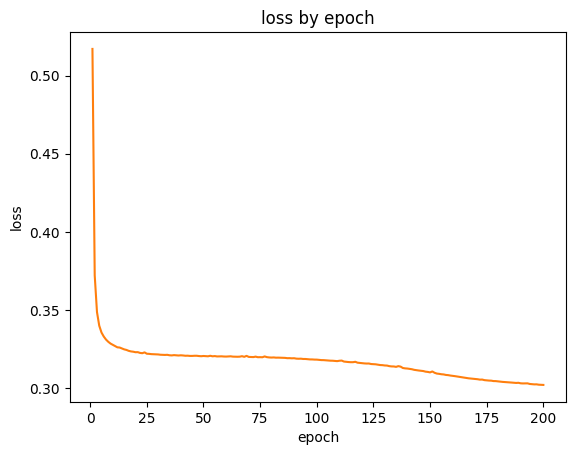

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Iterations, losses_val, color='tab:orange')


plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss by epoch')
plt.show()

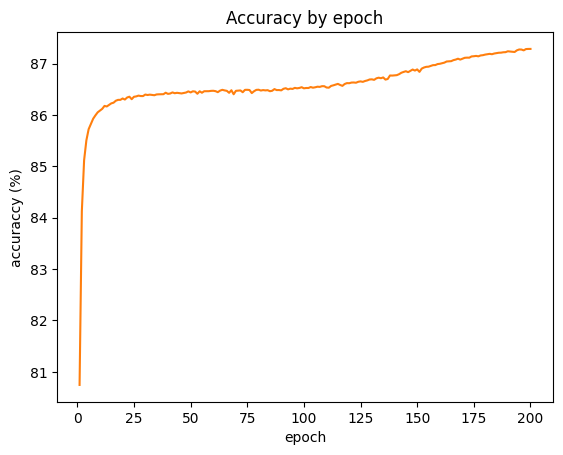

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Iterations, acc_val, color='tab:orange')


plt.xlabel('epoch')
plt.ylabel('accuraccy (%)')
plt.title('Accuracy by epoch')
plt.show()

In [16]:
model.load_state_dict(best_weights)

correct_test = 0
total_test = 0
outputs_test = torch.squeeze(model(X_gpu_test))
loss_test = criterion(outputs_test, y_gpu_test)

total_test += y_gpu_test.size(0)
correct_test += torch.eq(outputs_test.round(), y_gpu_test).sum()
accuracy_test = 100 * correct_test/total_test

In [17]:
accuracy_test.item()

87.18374633789062

In [18]:
# model_path = '../model/torch_softmax_sgd_384'
# torch.save(model.state_dict(), model_path)

In [19]:
from torcheval.metrics import BinaryAUROC

In [20]:
metric = BinaryAUROC()
metric.update(outputs_test, y_gpu_test)

In [21]:
metric.compute().item()

0.9432866183625